In [1]:
#Import Dependencies
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import datetime

In [2]:
# Load your data into a pandas DataFrame
df = pd.read_csv(r"C:\Users\owlsense.intern\Desktop\NOUMAN\Sceape Ethereum Data\Ethereum_data_10_march_2016_to_12_sept_2023.csv")

In [3]:
df.head()

,Date,Price,Open,High,Low,Vol,Change%
0,"Mar 10, 2016",11.75,11.20,11.85,11.07,0.0,4.91
1,"Mar 11, 2016",11.95,11.75,11.95,11.75,180.0,1.70
2,"Mar 12, 2016",12.92,11.95,13.45,11.95,830.0,8.12
3,"Mar 13, 2016",15.07,12.92,15.07,12.92,1300.0,16.64
4,"Mar 14, 2016",12.50,15.07,15.07,11.40,92180.0,-17.05


In [4]:
# Convert string columns to float (excluding the "Date" column)
float_columns = ['Price', 'Open', 'High', 'Low', 'Vol', 'Change%']
df[float_columns] = df[float_columns].apply(lambda x: x.astype(str).str.replace('%', '').str.replace(',', '').astype(float))

In [5]:
df.head()

,Date,Price,Open,High,Low,Vol,Change%
0,"Mar 10, 2016",11.75,11.20,11.85,11.07,0.0,4.91
1,"Mar 11, 2016",11.95,11.75,11.95,11.75,180.0,1.70
2,"Mar 12, 2016",12.92,11.95,13.45,11.95,830.0,8.12
3,"Mar 13, 2016",15.07,12.92,15.07,12.92,1300.0,16.64
4,"Mar 14, 2016",12.50,15.07,15.07,11.40,92180.0,-17.05


In [6]:
# Convert the "Date" column to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df.tail()

,Date,Price,Open,High,Low,Vol,Change%
2738,2023-09-08,1636.45,1648.09,1657.53,1618.39,236380.0,-0.71
2739,2023-09-09,1635.56,1636.45,1637.21,1630.12,63970.0,-0.05
2740,2023-09-10,1617.44,1635.56,1635.72,1604.26,220970.0,-1.11
2741,2023-09-11,1551.89,1617.44,1618.80,1533.95,444950.0,-4.05
2742,2023-09-12,1580.61,1551.89,1593.49,1549.71,512440.0,1.85


In [8]:
df.describe()

,Price,Open,High,Low,Vol,Change%
count,2743.000000,2743.000000,2743.000000,2743.000000,2.735000e+03,2743.000000
mean,955.708006,955.154214,985.154947,921.370397,6.041954e+06,0.323452
std,1102.980812,1103.076691,1135.751645,1065.290055,8.786497e+07,5.332859
min,6.700000,6.680000,7.320000,5.860000,0.000000e+00,-44.550000
25%,164.635000,164.485000,170.400000,158.700000,1.902650e+05,-2.080000
50%,369.970000,368.610000,380.770000,355.180000,4.960000e+05,0.040000
75%,1647.735000,1647.975000,1681.905000,1609.920000,8.343450e+05,2.700000
max,4808.380000,4808.340000,4864.060000,4715.430000,1.790000e+09,29.510000


In [9]:
df['Vol'].info() #here we found some null values (total entries: 2743, non_null:2735)

<class 'pandas.core.series.Series'>
RangeIndex: 2743 entries, 0 to 2742
Series name: Vol
Non-Null Count  Dtype  
--------------  -----  
2735 non-null   float64
dtypes: float64(1)
memory usage: 21.6 KB


In [10]:
df['Vol'] = df['Vol'].fillna(df['Vol'].mean()) #Fill nan values by mean

In [11]:
df['Vol'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2743 entries, 0 to 2742
Series name: Vol
Non-Null Count  Dtype  
--------------  -----  
2743 non-null   float64
dtypes: float64(1)
memory usage: 21.6 KB


In [12]:
df.corr()

C:\Users\owlsense.intern\AppData\Local\Temp\ipykernel_9592\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Price,Open,High,Low,Vol,Change%
Price,1.000000,0.998125,0.999076,0.999038,0.094237,-0.005792
Open,0.998125,1.000000,0.999303,0.998486,0.093301,-0.042795
High,0.999076,0.999303,1.000000,0.998287,0.094351,-0.024953
Low,0.999038,0.998486,0.998287,1.000000,0.094095,-0.020210
Vol,0.094237,0.093301,0.094351,0.094095,1.000000,0.004550
Change%,-0.005792,-0.042795,-0.024953,-0.020210,0.004550,1.000000


In [13]:
df.shape

(2743, 7)

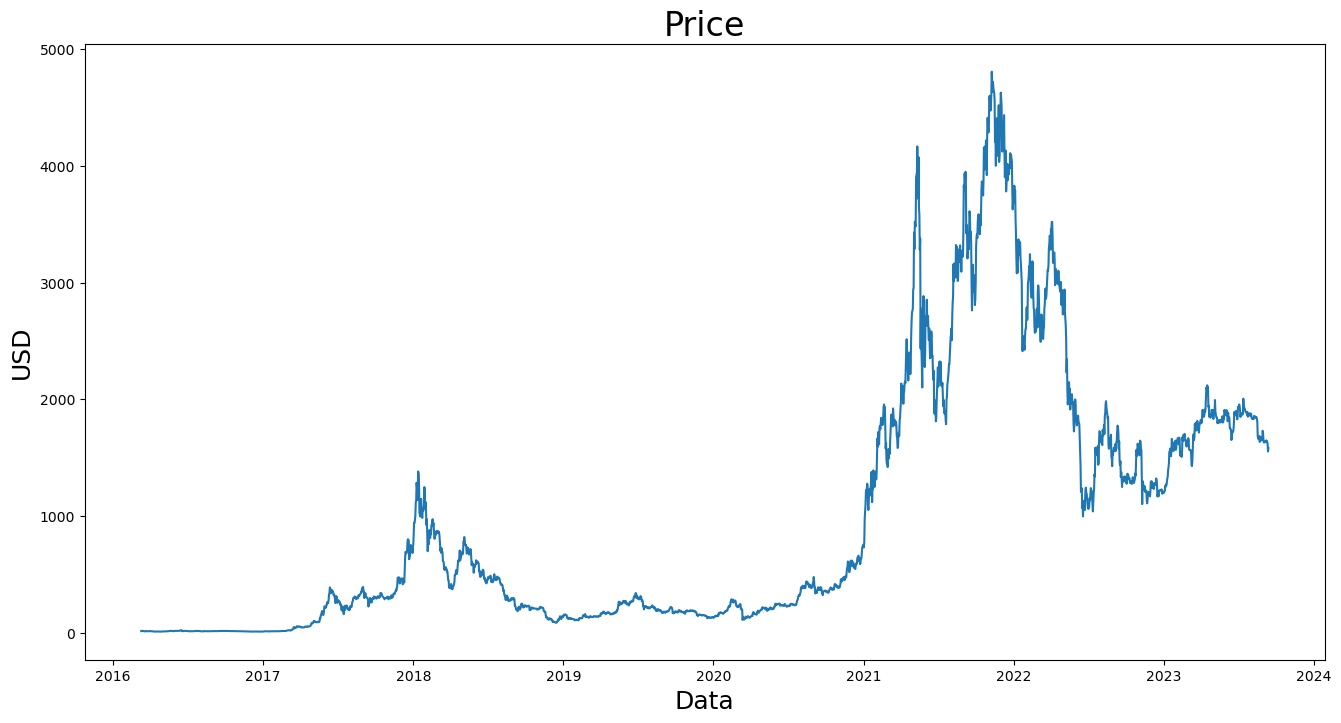

In [14]:
plt.figure(figsize=(16,8))
plt.title('Price', fontsize=24)
plt.plot(df.Date,df['Price'])
plt.xlabel('Data', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.show()

In [15]:
#Creat a new dataframe with only Price
data = df.filter(['Price'])
#Convert the dataframe to numpy array
dataset = data.values
'''
Get the number of rows to train the model on. 
we need this number to create our train and test sets
'''
# math.ceil will round up the number
training_data_len = math.ceil(len(dataset) * .8) # We are using %80 of the data for training
training_data_len
     

2195

In [16]:
#  Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00105172],
       [0.00109337],
       [0.00129538],
       ...,
       [0.33545342],
       [0.32180195],
       [0.32778319]])

In [17]:
# Creat the training dataset
train_data = scaled_data[0:training_data_len, :]
# Split the data into X_train and y_train data sets
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60: i, 0])
    y_train.append(train_data[i, 0])


    if i <= 60:
        print(X_train)
        print(y_train)
        print()

[array([0.00105172, 0.00109337, 0.00129538, 0.00174314, 0.00120791,
       0.00132454, 0.00128705, 0.00084137, 0.00084137, 0.00075182,
       0.00072475, 0.00109337, 0.00097258, 0.00119333, 0.00093717,
       0.00082679, 0.00089552, 0.00077056, 0.00102464, 0.00106005,
       0.00107254, 0.00098091, 0.00102464, 0.00102256, 0.00105172,
       0.00092676, 0.00077056, 0.00084554, 0.00071225, 0.00062686,
       0.00051024, 0.00042902, 0.00041236, 0.00017286, 0.00028948,
       0.00036654, 0.00033738, 0.0003832 , 0.0005748 , 0.00047275,
       0.0004186 , 0.00039778, 0.00029365, 0.00026449, 0.00036654,
       0.00029156, 0.00017494, 0.00016661, 0.00022909, 0.0001312 ,
       0.00017077, 0.00045193, 0.00042693, 0.00068726, 0.00054981,
       0.0005748 , 0.00064352, 0.00055189, 0.00055189, 0.00058313])]
[0.0005456423585078554]



In [18]:
len(X_train)

2135

In [19]:
# Convert the X_train and y_train to numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

In [20]:
X_train.shape

(2135, 60)

In [21]:
# Reshape the data because LSTM needs 3 dim
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) 
# we make it like pros. it wanna say "np.reshape(X_train, (2083, 60, 1))"
X_train.shape
     

(2135, 60, 1)

In [22]:
# Create the testing dataset
# Create a new array containing scaled values from index 2083
test_data = scaled_data[training_data_len - 60 : , :]

#Create the data sets X_test and y_test
X_test = []
y_test = dataset[training_data_len : , :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60 : i, 0])


In [23]:
# Convert the data to a numpy array 
X_test = np.array(X_test)

In [24]:
#reshape the test data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [25]:
X_train.shape

(2135, 60, 1)

In [26]:
# Build LSTM model
tf.random.set_seed(42)

model_1 = Sequential()
model_1.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) 
# we made it like pros ;) , the simple form is "input_shape(60, 1)""
model_1.add(LSTM(50, return_sequences=False))
model_1.add(Dense(25))
model_1.add(Dense(1))

In [27]:
# Compile the model
model_1.compile(optimizer='adam', loss='mse')

In [28]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model_1.fit(X_train, y_train, batch_size=1, epochs=51)

Epoch 1/51
2135/2135 [==============================] - 46s 20ms/step - loss: 0.0020
Epoch 2/51
2135/2135 [==============================] - 41s 19ms/step - loss: 7.6542e-04
Epoch 3/51
2135/2135 [==============================] - 44s 20ms/step - loss: 6.7620e-04
Epoch 4/51
2135/2135 [==============================] - 40s 19ms/step - loss: 5.5503e-04
Epoch 5/51
2135/2135 [==============================] - 40s 19ms/step - loss: 5.2326e-04
Epoch 6/51
2135/2135 [==============================] - 40s 19ms/step - loss: 4.9303e-04
Epoch 7/51
2135/2135 [==============================] - 41s 19ms/step - loss: 4.9362e-04
Epoch 8/51
2135/2135 [==============================] - 41s 19ms/step - loss: 4.4960e-04
Epoch 9/51
2135/2135 [==============================] - 40s 19ms/step - loss: 4.2558e-04
Epoch 10/51
2135/2135 [==============================] - 40s 19ms/step - loss: 4.3038e-04
Epoch 11/51
2135/2135 [==============================] - 40s 19ms/step - loss: 4.3731e-04
Epoch 12/51
2135/2135 [

In [29]:
# Get the model_1 predicted price values 
predictions_1 = model_1.predict(X_test)
predictions_1 = scaler.inverse_transform(predictions_1)
len(predictions_1)

18/18 [==============================] - 1s 15ms/step


548

In [30]:
# Get the root mean squared error (RMSE) for model_1
rmse = np.sqrt(np.mean(predictions_1 - y_test)**2)
rmse
     

4.4155172172602075

Text(0.5, 0, 'epochs')

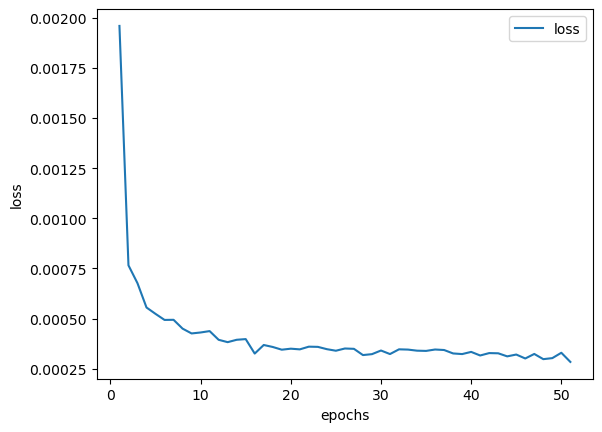

In [31]:
# Let's plot the history of model_1 and see what's going on
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [32]:
# Plot the data
train = data[:training_data_len]


In [33]:
train['Price'].shape, df.Date[:2195].shape

((2195,), (2195,))

C:\Users\owlsense.intern\AppData\Local\Temp\ipykernel_5168\2361588506.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_1['Predictions'] = predictions_1


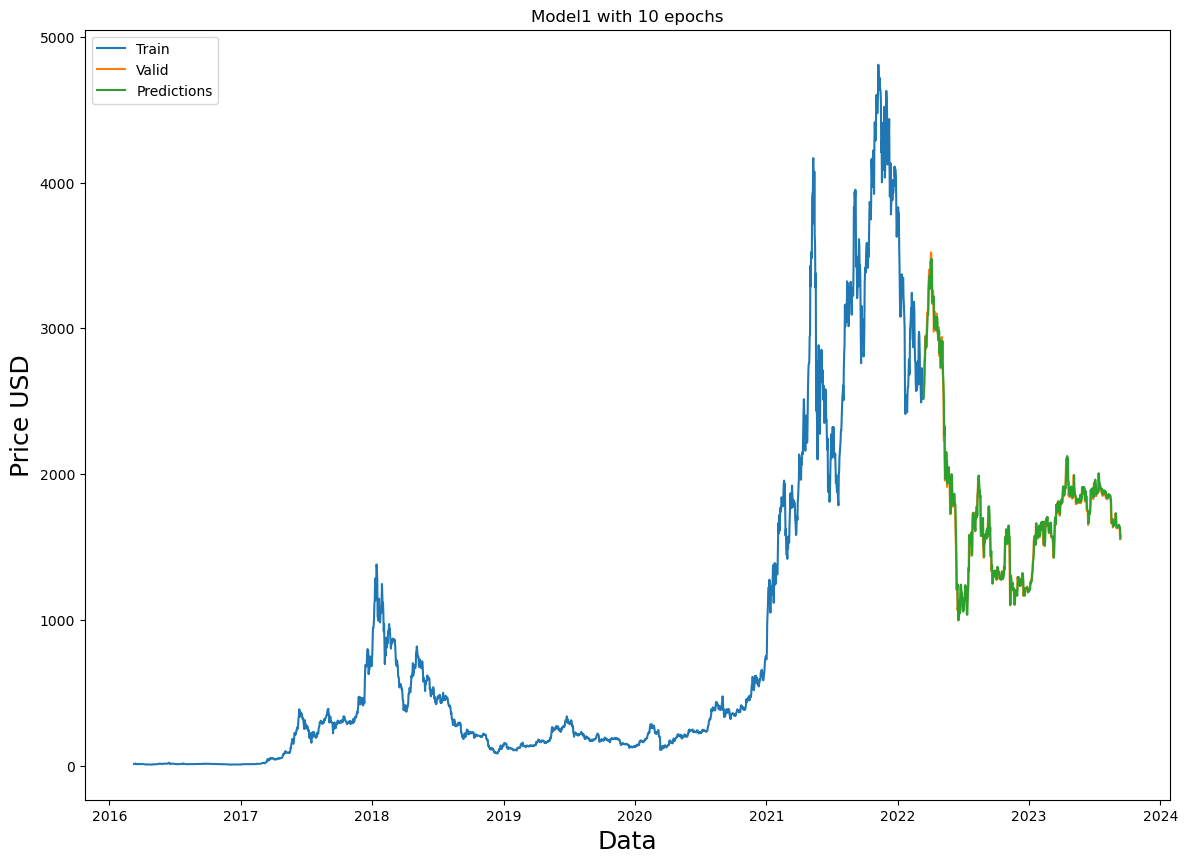

In [34]:

#data for model_1
valid_1 = data[training_data_len:]
valid_1['Predictions'] = predictions_1

# Visualized the data 
#model_1
plt.figure(figsize=(14, 10))
# plt.subplot(2, 1, 1)
plt.title('Model1 with 10 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Price USD', fontsize=18)
plt.plot(df.Date[:2195],train['Price'])
plt.plot(df.Date[2195:],valid_1[['Price', 'Predictions']])

plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

plt.show()

In [35]:
#Get the last 60 day price values and convert the datadrame to an array
last_60_days = data[-60:].values
# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.fit_transform(last_60_days)
# create an empty list
new_X_test = []
# Append the past 60 days
new_X_test.append(last_60_days_scaled)
# Convert the X_test data set to a numpy array
new_X_test = np.array(new_X_test)
# Reshape the data 
new_X_test = np.reshape(new_X_test, (new_X_test.shape[0], new_X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model_1.predict(new_X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)
#current date 12 sept 2023

1/1 [==============================] - 0s 31ms/step
[[1578.4235]]


1/1 [==============================] - 0s 39ms/step
[1578.4235, 1578.4235, 1578.4235, 1578.4235, 1578.4235, 1578.4235, 1578.4235]


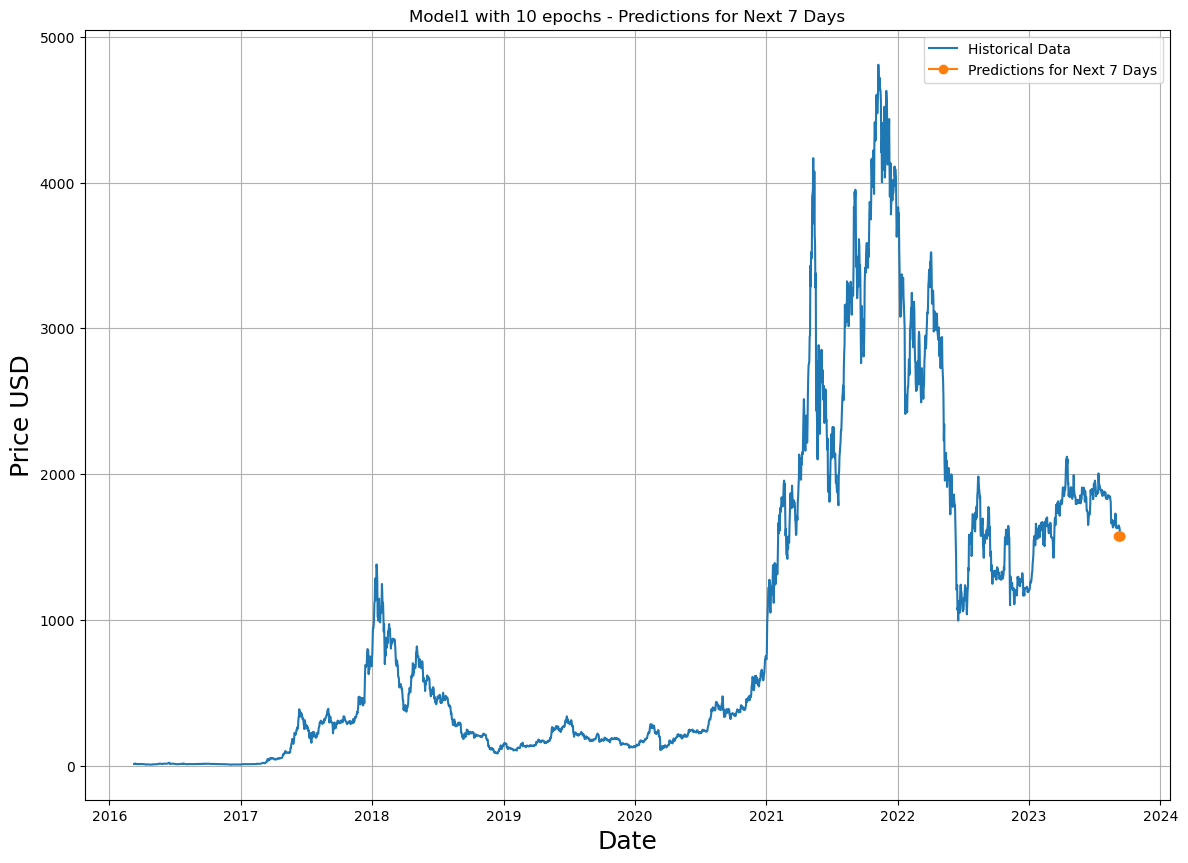

In [37]:
# Automate Date Updates
current_date = df['Date'].iloc[-1]  # Get the last available date in your data

# Predict stock prices for the next 7 days
predictions_7_days = []
for _ in range(7):
    # Get the last 60 days of data
    last_60_days = data[-60:].values
    last_60_days_scaled = scaler.transform(last_60_days)
    
    # Reshape and predict the next day's price
    new_X_test = np.array([last_60_days_scaled])
    new_X_test = np.reshape(new_X_test, (new_X_test.shape[0], new_X_test.shape[1], 1))
    pred_price = model_1.predict(new_X_test)
    pred_price = scaler.inverse_transform(pred_price)
    
    # Append the predicted price to the DataFrame
    current_date += datetime.timedelta(days=1)
    new_row = pd.DataFrame({'Date': [current_date], 'Open': [pred_price[0][0]]})
#     df = df.append(new_row, ignore_index=True)
    predictions_7_days.append(pred_price[0][0])
    
print(predictions_7_days)
# Plot the data with updated dates and predictions
plt.figure(figsize=(14, 10))
plt.title('Model1 with 10 epochs - Predictions for Next 7 Days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD', fontsize=18)
plt.plot(df['Date'], df['Price'], label='Historical Data')
plt.plot(df['Date'].iloc[-7:], predictions_7_days, label='Predictions for Next 7 Days', marker='o')
plt.legend()
plt.grid(True)
plt.show()